# prepare dataset and libraries

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('C:\\Users\\Saeth\\Downloads\\WIC_Dev_V1.csv')

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import math
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import tagset_mapping, map_tag
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
from sklearn.decomposition import PCA
import random
import warnings
warnings.filterwarnings("ignore") 

In [5]:
maxy = max(data['freq'])
maxy

1461750

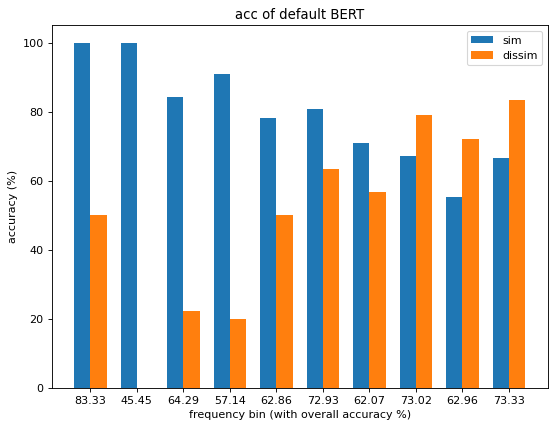

overall acc:  66.667


In [6]:
# baseline
no_bin=10
# 3399860
# 3895208
move = np.log2(maxy)/no_bin
rec= {i+1:[0,0,0,0] for i in range(10)} # sim[true], sim[all], dissim[true], dissim[all]

score = 0 # overall acc
for index in range(len(data)):
    emb1 = torch.tensor([float(i) for i in data.iloc[index]['emb1'][1:-2].split(',')])
    emb2 = torch.tensor([float(i) for i in data.iloc[index]['emb2'][1:-2].split(',')])
    log2_freq = data.iloc[index]['log2freq']
    cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2)))

    if cos >= 0.5447465400847086:
        temp = 'T'
    else:
        temp = 'F'
    lol=False
    label = data.iloc[index]['human_label']
    if temp == label:
        score+=1
        lol=True
    for j in range(10):
        left = j*move
        if log2_freq<left:
            if label == 'T':
                rec[j][1]+=1
                if lol:
                    rec[j][0]+=1
            else:
                rec[j][3]+=1
                if lol:
                    rec[j][2]+=1
            break
        if j==9:
            if label == 'T':
                rec[j+1][1]+=1
                if lol:
                    rec[j+1][0]+=1
            else:
                rec[j+1][3]+=1
                if lol:
                    rec[j+1][2]+=1
#print(rec)
figure(figsize=(8, 6), dpi=80)
N = 10
#men_means = (20, 35, 30, 35, 27)
#women_means = (25, 32, 34, 20, 25)
x=[j for j in range(1,11)]
ind = np.arange(N) 
width = 0.35
y=[]
for g in list(rec.values()):
    if g[1] != 0:
        y.append((g[0]/g[1])*100)
    else:
        y.append(0)
plt.bar(ind, y, width, label='sim')
y2=[]
for h in  list(rec.values()):
    if h[3] !=0:
        y2.append((h[2]/h[3])*100)
    else:
        y2.append(0)
plt.bar(ind + width, y2, width,
    label='dissim')

#plt.bar(ind + 2*width, [(h[0]+h[2])/(h[3]+h[1]) for h in list(rec.values())], width,
    #label='overall')

plt.ylabel('accuracy (%)')
plt.xlabel('frequency bin (with overall accuracy %)')
plt.title('acc of default BERT')

y3=[]
for h in list(rec.values()):
    if h[3]+h[1] != 0:
        y3.append((h[0]+h[2])/(h[3]+h[1]))
    else:
        y3.append(0)
default_result = ["{:.2f}".format(k*100) for k in y3]
default_all_acc = [k*100 for k in y3]

plt.xticks(ind + width/2, default_result)
plt.legend(loc='best')
plt.show()

default_gap = np.array([abs(i) for i in np.array(y)-np.array(y2)])
default_acc = (score/len(data))*100
print('overall acc: ', "{:.3f}".format(default_acc))

In [7]:
default_gap

array([ 50.        , 100.        ,  61.98830409,  70.90909091,
        28.125     ,  17.48858447,  14.24242424,  11.84475806,
        16.82758621,  16.66666667])

In [8]:
default_acc

66.66666666666666

In [9]:
default_all_acc

[83.33333333333334,
 45.45454545454545,
 64.28571428571429,
 57.14285714285714,
 62.857142857142854,
 72.93233082706767,
 62.06896551724138,
 73.01587301587301,
 62.96296296296296,
 73.33333333333333]

# test results

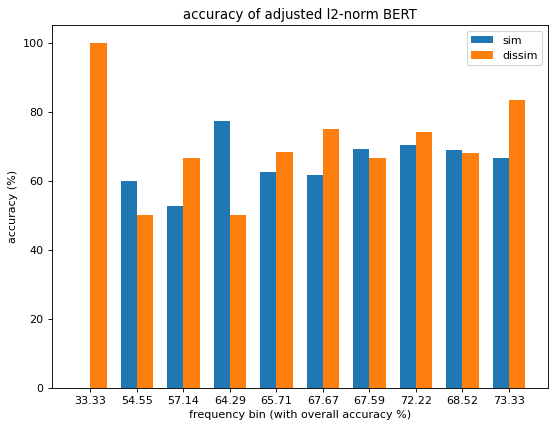

overall acc:  67.302


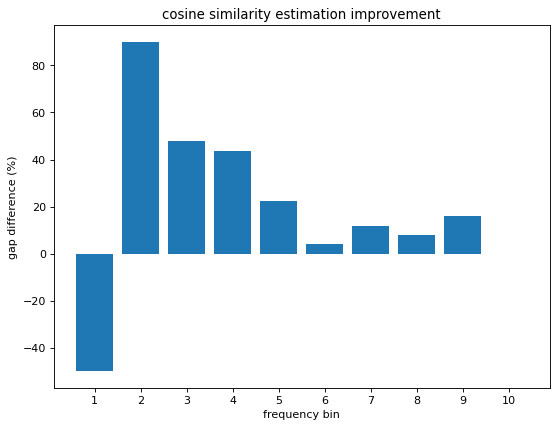

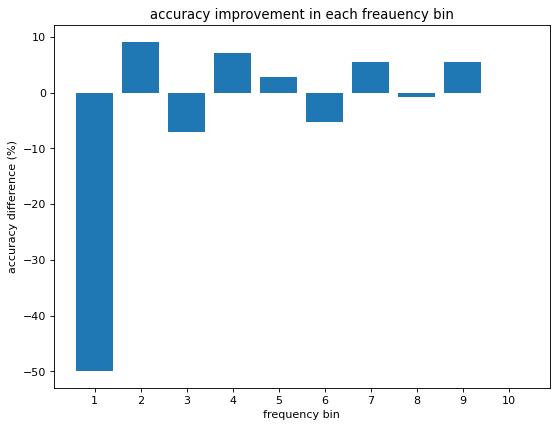

Delta accuracy (%):  0.635
Average gap improvement (%):  19.357
objective function:  0.167


In [19]:
# alpha = -0.01* bin + 1.06

no_bin=10
# 3399860
# 3895208
move = np.log2(maxy)/no_bin
rec= {i+1:[0,0,0,0] for i in range(10)}
m1 = 0.023
t1 = 14.5
m2 = 0.03

m3 = 0.02
m4 = 0.005
t2 = 14.65
score = 0
for index in range(len(data)):
    emb1 = torch.tensor([float(i) for i in data.iloc[index]['emb1'][1:-2].split(',')])
    emb2 = torch.tensor([float(i) for i in data.iloc[index]['emb2'][1:-2].split(',')])
    log2_freq = data.iloc[index]['log2freq']
    
    if (data.iloc[index]['keyword'] not in gensim.parsing.preprocessing.STOPWORDS):
        if log2_freq>= t1:
            alpha = (-m1* log2_freq) + 1 + t1*m1
            # non_stop words m1 lowest
            cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2))*alpha)
        else:
            alpha = (-m2* log2_freq) + 1 + t1*m2
            # non_stop words m1 lowest
            cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2))*alpha)
    else:
        if log2_freq>= t2:
            alpha = (-m3* log2_freq) + 1 + t2*m3
            # non_stop words m1 lowest
            cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2))*alpha)
        else:
            alpha = (-m4* log2_freq) + 1 + t2*m4
            # non_stop words m1 lowest
            cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2))*alpha)
   
    if cos >= 0.5447465400847086:
        temp = 'T'
    else:
        temp = 'F'
    lol=False
    label = data.iloc[index]['human_label']
    if temp == label:
        score+=1
        lol=True
    for j in range(10):
        left = j*move
        if log2_freq<left:
            if label == 'T':
                rec[j][1]+=1
                if lol:
                    rec[j][0]+=1
            else:
                rec[j][3]+=1
                if lol:
                    rec[j][2]+=1
            break
        if j==9:
            if label == 'T':
                rec[j+1][1]+=1
                if lol:
                    rec[j+1][0]+=1
            else:
                rec[j+1][3]+=1
                if lol:
                    rec[j+1][2]+=1

figure(figsize=(8, 6), dpi=80)
N = 10
#men_means = (20, 35, 30, 35, 27)
#women_means = (25, 32, 34, 20, 25)
x=[j for j in range(1,11)]
ind = np.arange(N) 
width = 0.35     
y = [(g[0]/g[1])*100 for g in list(rec.values())]
plt.bar(ind, y, width, label='sim')
y2=[(h[2]/h[3])*100 for h in list(rec.values())]
plt.bar(ind + width, y2, width,
    label='dissim')

#plt.bar(ind + 2*width, [(h[0]+h[2])/(h[3]+h[1]) for h in list(rec.values())], width,
    #label='overall')

plt.ylabel('accuracy (%)')
plt.xlabel('frequency bin (with overall accuracy %)')
plt.title('accuracy of adjusted l2-norm BERT')

y3 = ["{:.2f}".format(((h[0]+h[2])/(h[3]+h[1]))*100) for h in list(rec.values())]
plt.xticks(ind + width/2, y3)
plt.legend(loc='best')
plt.show()


print('overall acc: ', "{:.3f}".format((score/len(data))*100))

# obj function
all_gap = default_gap - np.array([abs(i) for i in np.array(y)-np.array(y2)])
delta_gap = (1/no_bin)*np.sum(all_gap)
delta_acc = (score/len(data)*100) - default_acc
y3 = [((h[0]+h[2])/(h[3]+h[1]))*100 for h in list(rec.values())]
delta_all_acc = (1/no_bin)*np.sum(np.array(y3) - np.array(default_all_acc))
obj = (delta_gap + delta_all_acc + delta_acc)/100

figure(figsize=(8, 6), dpi=80)
#print(y2)
plt.bar(x, all_gap)
plt.xlabel('frequency bin')
plt.ylabel('gap difference (%)')
plt.title('cosine similarity estimation improvement')
plt.xticks(x)
plt.show()

figure(figsize=(8, 6), dpi=80)
#print(y2)
plt.bar(x, np.array(y3) - np.array(default_all_acc))
plt.xlabel('frequency bin')
plt.ylabel('accuracy difference (%)')
plt.title('accuracy improvement in each freauency bin')
plt.xticks(x)
plt.show()

print('Delta accuracy (%): ', "{:.3f}".format(delta_acc))
print('Average gap improvement (%): ', "{:.3f}".format(delta_gap))
print('objective function: ', "{:.3f}".format(obj))